In [2]:
import torch
import random
import numpy as np
import os
import pickle
import pandas as pd
from sklearn.model_selection import RepeatedKFold
from pysurvival.models.multi_task import NeuralMultiTaskModel
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index

In [4]:
from pysurvival.utils.metrics import concordance_index
from sklearn.model_selection import RepeatedKFold
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel
class BaseFun:
    def parse_param(self, param):
        for key in param:
            if isinstance(param[key], str):
                param[key] = '"{}"'.format(param[key])
        return ','.join(['{} = {}'.format(key, param[key]) for key in param])
    def get_random_param(self,space):
        param = {}
        for key in space:
            if  key == 'structure':
                items = []
                for i in range(1,random.choice(space['structure']['num_layers'])+1):
                    items.append(
                        {
                        'activation': random.choice(space['structure']['activations']),
                        'num_units':random.choice(space['structure']['num_units'])
                        }
                    )
                param['structure'] = items
            else:
                param[key] = random.choice(space[key])
        return param
    
    def tuning_and_construct(self,X, T, E,max_iter=100):
        self.tuning_result = self.tuning_with_space(X, T, E,self.space,max_iter=max_iter)
        self.model = self.fit_model(X, T, E,**self.tuning_result['best_param'])
        return self.model
    def tuning_with_space(self,x,t,e,space,max_iter=100):
        [x,t,e] = [item if isinstance(item, np.ndarray) else np.array(item) for item in [x,t,e]]
        scores = []
        best_score = 0
        best_param = {}
        num = 1
        while True:
            param = self.get_random_param(space)
            print(param)
            print('Number {} iteration'.format(num), end=' ... ')
            # split train data to 5 parts
            rkf = RepeatedKFold(n_splits=5, n_repeats=1)
            score_iter = []
            for train_index, test_index in rkf.split(x):
                x_train, x_test = x[train_index], x[test_index]
                t_train, t_test = t[train_index], t[test_index]
                e_train, e_test = e[train_index], e[test_index]
                try:
                    model = self.fit_model(x_train, t_train, e_train,**param)
                    score = concordance_index(model, x_test, t_test, e_test)
                except Exception as err:
                    print(str(err))
                    break
                score_iter.append(score)
            mean_score = np.mean(score_iter)
            print('mean_c_index: ', mean_score, end=' ')
            if mean_score > best_score:
                best_score = mean_score
                best_param = param
                print('is the best so far')
            else:
                print('')
            scores.append({'iteration':num,'mean_score': mean_score, 'param': param})
            if num == max_iter:
                break
            num += 1
        return {'best_param': best_param, 'best_score': best_score, 'scores': scores}


from pysurvival.models.multi_task import NeuralMultiTaskModel
class NMTLR(BaseFun):
    def __init__(self):
        self.space = {
            'structure': {'num_layers':[1,2,3,4,5],
                          'num_units': [i for i in range(8, 100)],
                          'activations': ["Atan", "BentIdentity", "BipolarSigmoid", "CosReLU", 
                                           "Gaussian", "Hardtanh", "InverseSqrt", "LeakyReLU", 
                                          "LeCunTanh", "LogLog", "LogSigmoid", "ReLU", "SELU", "Sigmoid", 
                                          "Sinc", "SinReLU","Softmax", "Softplus", "Softsign", "Swish", "Tanh"]
                         },
            'optimizer':['adadelta','adagrad','adam','adamax','rmsprop','sgd'],
            'bins' : [i for i in range(10,100)],
            'lr': [round(1e-5 * i, 5) for i in range(1, 100 + 1)],
            'num_epochs': [i for i in range(50, 1000 + 1)],
            'dropout': [round(0.1 * i, 2) for i in range(1, 4 + 1)],
            'l2_reg': [round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'l2_smooth':[round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'batch_normalization' : [False, True]
        }
        self.model = None
    def fit_model(self,X, T, E,**kwargs):
        structure = [{'activation': 'ReLU', 'num_units': 128}]
        bins = 100
        if 'structure' in kwargs:
            structure = kwargs['structure']
            del kwargs['structure']
        if 'bins' in kwargs:
            bins = kwargs['bins']
            del kwargs['bins']
        self.model = NeuralMultiTaskModel(structure=structure,bins=bins)
        eval('self.model.fit(X, T, E,{})'.format(self.parse_param(kwargs)))
        return self.model

from pysurvival.models.semi_parametric import NonLinearCoxPHModel
class DeepSurv(BaseFun):
    def __init__(self):
        self.space = {
            'structure': {'num_layers':[1,2,3,4,5],
                          'num_units': [i for i in range(8, 100)],
                          'activations': ["Atan", "BentIdentity", "BipolarSigmoid", "CosReLU", 
                                           "Gaussian", "Hardtanh", "InverseSqrt", "LeakyReLU", 
                                          "LeCunTanh", "LogLog", "LogSigmoid", "ReLU", "SELU", "Sigmoid", 
                                          "Sinc", "SinReLU","Softmax", "Softplus", "Softsign", "Swish", "Tanh"]
                         },
            'optimizer':['adadelta','adagrad','adam','adamax','rmsprop','sgd'],
            'lr': [round(1e-5 * i, 5) for i in range(1, 100 + 1)],
            'num_epochs': [i for i in range(50, 5000 + 1)],
            'dropout': [round(0.1 * i, 2) for i in range(1, 4 + 1)],
            'l2_reg': [round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'batch_normalization' : [False, True]
        }
        self.model = None
    def fit_model(self,X, T, E,**kwargs):
        structure = [{'activation': 'ReLU', 'num_units': 128}]
        bins = 100
        if 'structure' in kwargs:
            structure = kwargs['structure']
            del kwargs['structure']
        self.model = NonLinearCoxPHModel(structure=structure)
        eval('self.model.fit(X, T, E,{})'.format(self.parse_param(kwargs)))
        return self.model


from pysurvival.models.survival_forest import RandomSurvivalForestModel
class RSF(BaseFun):
    def __init__(self):
        self.space = {
            'num_trees': [i for i in range(20, 1000 + 1)],
            'max_features': ['sqrt', 'log2', 'all', 0.1, 0.2],
            'min_node_size': [i for i in range(5, 80 + 1)],
            'sample_size_pct': [round(0.2 * i, 2) for i in range(1, 4 + 1)],
            'importance_mode': ['impurity', 'impurity_corrected', 'permutation', 'normalized_permutation']
        }
        self.model = None
    def fit_model(self,X, T, E,**kwargs):
        if 'num_trees' in kwargs:
            self.model = RandomSurvivalForestModel(num_trees=kwargs['num_trees'])
            del kwargs['num_trees']
        else:
            self.model = ConditionalSurvivalForestModel()
        eval('self.model.fit(X, T, E,seed=SEED,{})'.format(self.parse_param(kwargs)))
        return self.model

In [5]:
def seed_all(seed=123):  
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2025
seed_all(seed=SEED)

In [9]:
df1train = pd.read_csv('data/subset1_train.csv')
df1test = pd.read_csv('data/subset1_test.csv')
df2train = pd.read_csv('data/subset2_train.csv')
df2test = pd.read_csv('data/subset2_test.csv')
df3test = pd.read_csv('data/subset3_test.csv')
df3train = pd.read_csv('data/subset3_train.csv')
df1train = df1train.drop(df1train.columns[0], axis=1)
df1test = df1test.drop(df1test.columns[0], axis=1)
df2train = df2train.drop(df2train.columns[0], axis=1)
df2test = df2test.drop(df2test.columns[0], axis=1)
df3train = df3train.drop(df3train.columns[0], axis=1)
df3test = df3test.drop(df3test.columns[0], axis=1)
df2 = pd.concat([df2train, df2test])
df3 = pd.concat([df3train, df3test])



In [11]:
time_column = 'Overall Survival (Months)'
event_column = 'Vital Status'
features = [col for col in df1train.columns if col not in [time_column, event_column,'WHO Grade']]

In [12]:
X_train, X_test = df1train[features], df1test[features]
T_train, T_test = df1train[time_column], df1test[time_column]
E_train, E_test = df1train[event_column], df1test[event_column]
X2 = df2[features]
T2 = df2[time_column] 
E2 = df2[event_column]
X3 = df3[features]
T3 = df3[time_column] 
E3 = df3[event_column]


In [13]:
print(X_train.shape, X_test.shape)
print(T_train.shape, T_test.shape)
print(E_train.shape, E_test.shape)
print(X2.shape)
print(T2.shape)
print(E2.shape)
print(X3.shape)
print(T3.shape)
print(E3.shape)



(6187, 13) (1536, 13)
(6187,) (1536,)
(6187,) (1536,)
(5576, 13)
(5576,)
(5576,)
(9200, 13)
(9200,)
(9200,)


Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 28843.253 - ||grad||^2 = 7624.76501
 * Iteration #2 - Loss = 27486.272 - ||grad||^2 = 6043.99738
 * Iteration #3 - Loss = 26857.841 - ||grad||^2 = 4882.25817
 * Iteration #4 - Loss = 26457.969 - ||grad||^2 = 3964.08536
 * Iteration #5 - Loss = 26180.600 - ||grad||^2 = 3226.60006
 * Iteration #6 - Loss = 25979.273 - ||grad||^2 = 2629.45575
 * Iteration #7 - Loss = 25829.114 - ||grad||^2 = 2143.34719
 * Iteration #8 - Loss = 25715.490 - ||grad||^2 = 1745.98984
 * Iteration #9 - Loss = 25629.292 - ||grad||^2 = 1420.18612
 * Iteration #10 - Loss = 25564.488 - ||grad||^2 = 1152.65983
 * Iteration #11 - Loss = 25516.669 - ||grad||^2 = 933.13763
 * Iteration #12 - Loss = 25482.230 - ||grad||^2 = 753.50268
 * Iteration #13 - Loss = 25458.038 - ||grad||^2 = 607.09310
 * Iteration #14 - Loss = 25441.417 - ||grad||^2 = 488.25880
 * Iteration #15 - Loss = 25430.199 - ||grad||^2 = 392.15439
 * Iteration #16 - Loss = 25422.729 - ||grad|

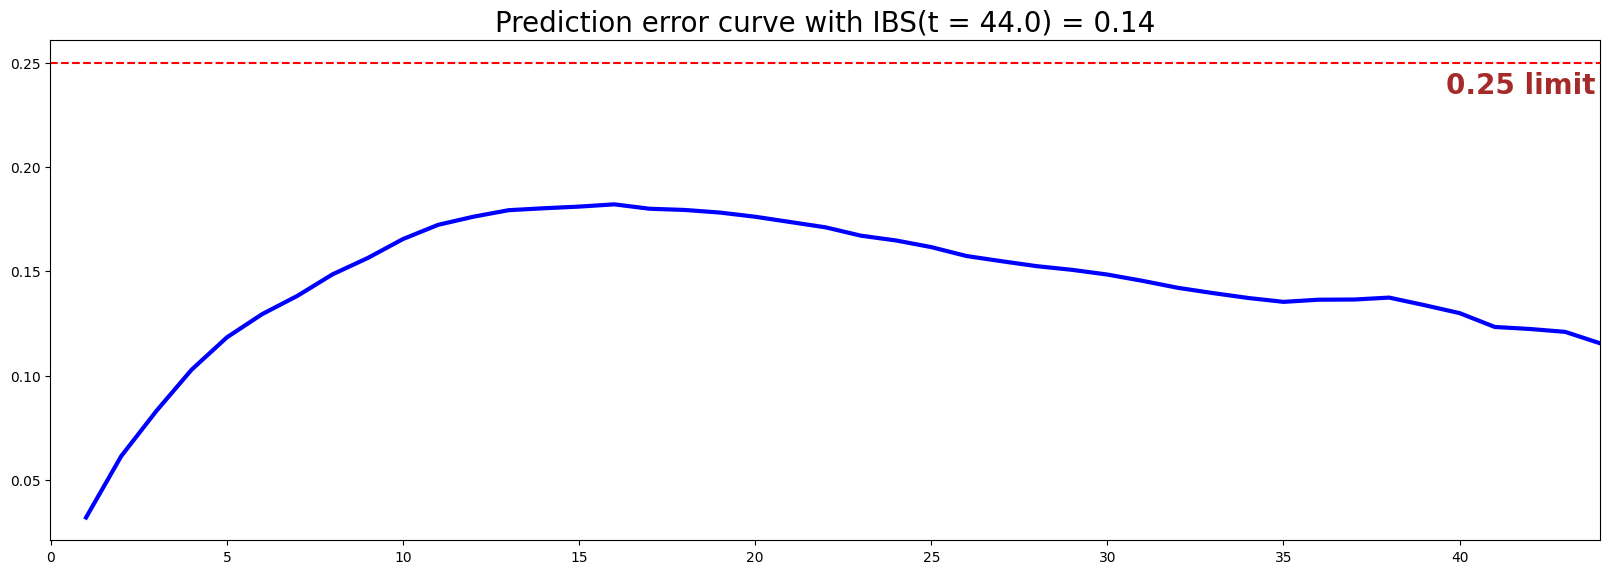

IBS: 0.143


In [14]:
from pysurvival.models.semi_parametric import CoxPHModel
def cph(X_train, T_train, E_train):
    model = CoxPHModel()
    model.fit(X_train, T_train, E_train, lr=0.2, l2_reg=0.01)
    return model

cph_model = cph(X_train, T_train, E_train)
c_index_cox_train = concordance_index(cph_model, X_train, T_train, E_train)
c_index_cox_test = concordance_index(cph_model, X_test, T_test, E_test)

print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_cox_train,c_index_cox_test))

# from pysurvival.utils import save_model
# save_model(cph_model, './outputModel_1/CoxPH.zip')
from pysurvival.utils.display import integrated_brier_score
ibs_cox = integrated_brier_score(cph_model, X_train, T_train, E_train,t_max=None, figure_size=(20, 6.5) )
print('IBS: {:.3f}'.format(ibs_cox))


% Completion: 100%|**********************************************|Loss: 8892.57


C-index of train: 0.7731; C-index of test: 0.7764


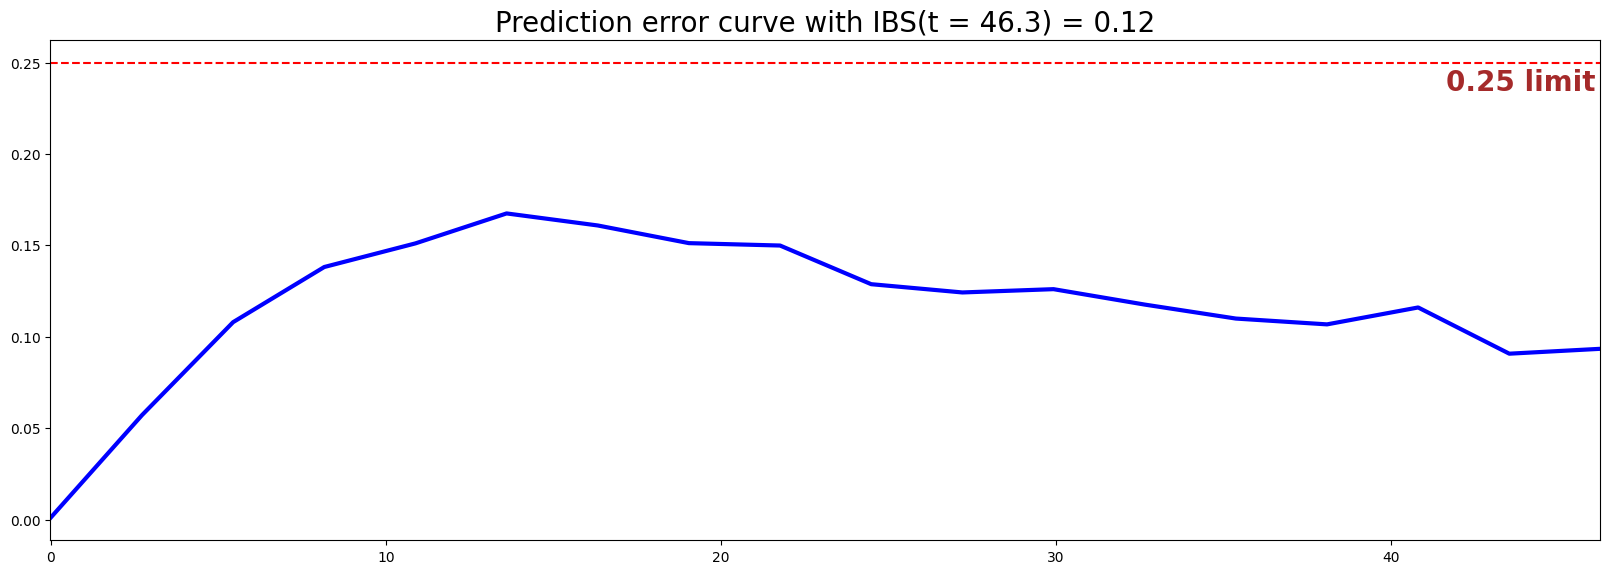

IBS: 0.12


In [15]:
var_nmtlr = {'structure': [{'activation': 'Swish', 'num_units': 64}, {'activation': 'Swish', 'num_units': 31}, {'activation': 'Swish', 'num_units': 62}, {'activation': 'LeakyReLU', 'num_units': 91}, {'activation': 'BentIdentity', 'num_units': 92}], 'optimizer': 'adam', 'bins': 20, 'lr': 0.00069, 'num_epochs': 276, 'dropout': 0.4, 'l2_reg': 0.0034, 'l2_smooth': 0.0092, 'batch_normalization': False}
nmtlr = NMTLR()
nmtlr.fit_model(X_train,T_train,E_train,**var_nmtlr)
c_index_nmtlr_train = concordance_index(nmtlr.model, X_train, T_train, E_train)
c_index_nmtlr_test = concordance_index(nmtlr.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_nmtlr_train, c_index_nmtlr_test))


ibs_nmtlr = integrated_brier_score(nmtlr.model, X_test, T_test, E_test, figure_size=(20, 6.5))
print('IBS: {:.2f}'.format(ibs_nmtlr))

% Completion: 100%|*********************************************|Loss: 24840.80


C-index of train: 0.7782; C-index of test: 0.7806


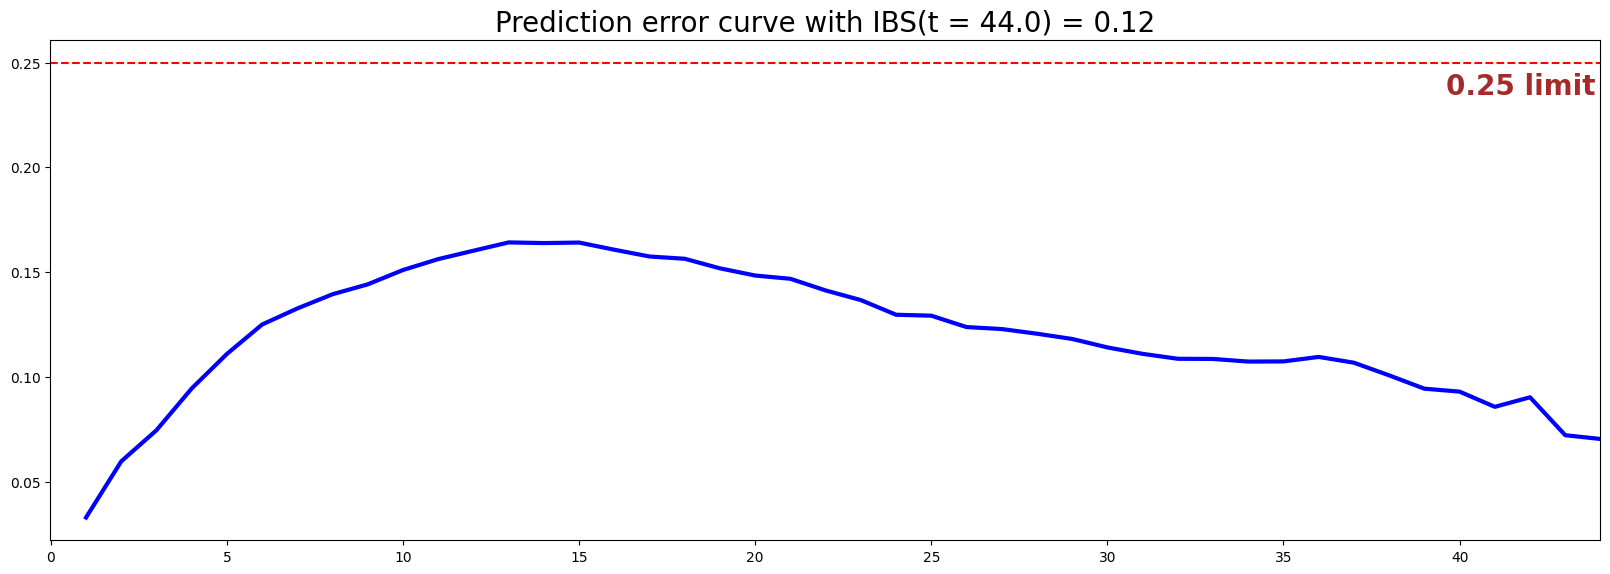

IBS: 0.119


In [16]:
var_deepsurv = {'structure': [{'activation': 'Swish', 'num_units': 66}], 'optimizer': 'rmsprop', 'lr': 0.00037, 'num_epochs': 3188, 'dropout': 0.3, 'l2_reg': 0.0098, 'batch_normalization': False}
deepsurv = DeepSurv()
deepsurv.fit_model(X_train,T_train,E_train,**var_deepsurv)
c_index_deepsurv_train = concordance_index(deepsurv.model, X_train, T_train, E_train)
c_index_deepsurv_test = concordance_index(deepsurv.model, X_test, T_test, E_test)

print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_deepsurv_train,c_index_deepsurv_test)) #C-index: 0.6996

from pysurvival.utils.display import integrated_brier_score
ibs_deepsurv = integrated_brier_score(deepsurv.model, X_test, T_test, E_test, figure_size=(20, 6.5) )
print('IBS: {:.3f}'.format(ibs_deepsurv))

C-index of train: 0.7675; C-index of test: 0.7657


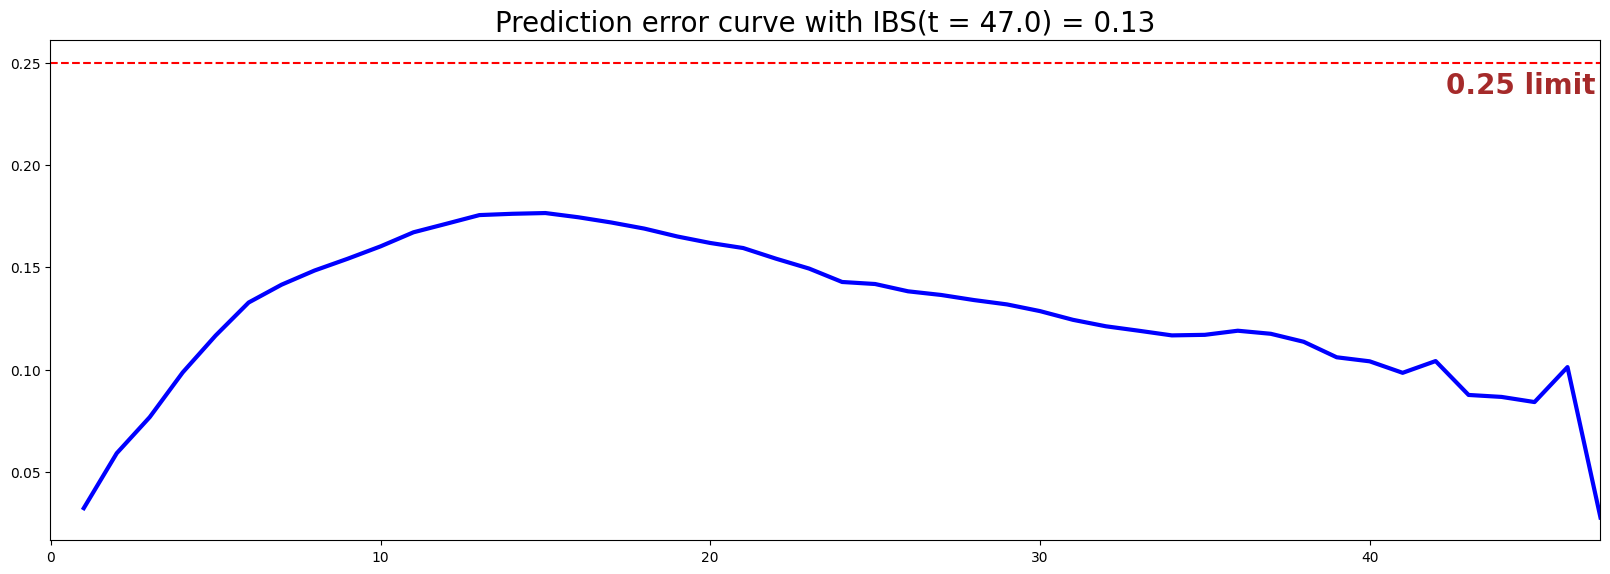

IBS: 0.127


In [17]:
var_rsf = {'num_trees': 66, 'max_features': 'sqrt', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}
rsf = RSF()
rsf.fit_model(X_train,T_train,E_train,**var_rsf)
c_index_rsf_train = concordance_index(rsf.model, X_train, T_train, E_train)
c_index_rsf_test = concordance_index(rsf.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_rsf_train,c_index_rsf_test))

from pysurvival.utils.display import integrated_brier_score
ibs_rsf = integrated_brier_score(rsf.model, X_test, T_test, E_test, figure_size=(20, 6.5) )
print('IBS: {:.3f}'.format(ibs_rsf))

In [122]:
c_index_cox2 = concordance_index(cph_model, X2, T2, E2)
c_index_cox3 = concordance_index(cph_model, X3, T3, E3)
print('C-index of cox subset2: {:.4f}; C-index of cox subset3: {:.4f}'.format(c_index_cox2,c_index_cox3))
c_index_nmtlr2 = concordance_index(nmtlr.model, X2, T2, E2)
c_index_nmtlr3 = concordance_index(nmtlr.model, X3, T3, E3)
print('C-index of nmtlr subset2: {:.4f}; C-index of nmtlr subset3: {:.4f}'.format(c_index_nmtlr2,c_index_nmtlr3))
c_index_deepsurv2 = concordance_index(deepsurv.model, X2, T2, E2)
c_index_deepsurv3 = concordance_index(deepsurv.model, X3, T3, E3)
print('C-index of deepsurv subset2: {:.4f}; C-index of deepsurv subset3: {:.4f}'.format(c_index_deepsurv2,c_index_deepsurv3))
c_index_rsf2 = concordance_index(rsf.model, X2, T2, E2)
c_index_rsf3 = concordance_index(rsf.model, X3, T3, E3)
print('C-index of rsf subset2: {:.4f}; C-index of rsf subset3: {:.4f}'.format(c_index_rsf2,c_index_rsf3))


C-index of subset2: 0.6966; C-index of subset3: 0.7493
C-index of subset2: 0.7229; C-index of subset3: 0.7844
C-index of subset2: 0.7256; C-index of subset3: 0.7876
C-index of subset2: 0.7201; C-index of subset3: 0.7763


In [18]:
from pysurvival.utils.metrics import brier_score
t_max = max(T_test)

times_nmtlr2, brier_scores_nmtlr2 = brier_score(nmtlr.model, X2, T2, E2, t_max=t_max, use_mean_point=True)
ibs_nmtlr2 = np.trapz(brier_scores_nmtlr2, times_nmtlr2) / t_max
times_nmtlr3, brier_scores_nmtlr3 = brier_score(nmtlr.model, X3, T3, E3, t_max=t_max, use_mean_point=True)
ibs_nmtlr3 = np.trapz(brier_scores_nmtlr3, times_nmtlr3) / t_max
print("IBS of nmtlr subset2: {:.4f}; IBS of nmtlr subset3: {:.4f}".format(ibs_nmtlr2, ibs_nmtlr3))

times_deepsurv2, brier_scores_deepsurv2 = brier_score(deepsurv.model, X2, T2, E2, t_max=t_max,
                                                    use_mean_point=True)
ibs_deepsurv2 = np.trapz(brier_scores_deepsurv2, times_deepsurv2) / t_max
times_deepsurv3, brier_scores_deepsurv3 = brier_score(deepsurv.model, X3, T3, E3, t_max=t_max,
                                                    use_mean_point=True)
ibs_deepsurv3 = np.trapz(brier_scores_deepsurv3, times_deepsurv3) / t_max
print("IBS of deepsurv subset2: {:.4f}; IBS of deepsurv subset3: {:.4f}".format(ibs_deepsurv2, ibs_deepsurv3))

times_rsf2, brier_scores_rsf2 = brier_score(rsf.model, X2, T2, E2, t_max=t_max, use_mean_point=True)
ibs_rsf2 = np.trapz(brier_scores_rsf2,  times_rsf2) / t_max
times_rsf3, brier_scores_rsf3 = brier_score(rsf.model, X3, T3, E3, t_max=t_max, use_mean_point=True)
ibs_rsf3 = np.trapz(brier_scores_rsf3, times_rsf3) / t_max
print("IBS of rsf subset2: {:.4f}; IBS of rsf subset3: {:.4f}".format(ibs_rsf2, ibs_rsf3))

times_cph2, brier_scores_cph2 = brier_score(cph_model, X2, T2, E2, t_max=t_max, use_mean_point=True)
ibs_cph2 = np. trapz(brier_scores_cph2, times_cph2)/t_max
times_cph3, brier_scores_cph3 = brier_score(cph_model, X3, T3, E3, t_max=t_max, use_mean_point=True)
ibs_cph3 = np.trapz(brier_scores_cph3, times_cph3)/t_max
print("IBS of cph subset2: {:.4f}; IBS of cph subset3: {:.4f}".format(ibs_cph2, ibs_cph3))


IBS of nmtlr subset2: 0.1257; IBS of nmtlr subset3: 0.1103
IBS of deepsurv subset2: 0.1206; IBS of deepsurv subset3: 0.1060
IBS of rsf subset2: 0.1318; IBS of rsf subset3: 0.1209
IBS of cph subset2: 0.1411; IBS of cph subset3: 0.1337


In [19]:
save_path = 'save/final1'

In [16]:
import pickle
with open('save/DeepSurv.pkl', 'wb') as f:
    pickle.dump(deepsurv.model, f)
# with open('save/DeepSurv.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

In [127]:
from pysurvival.utils.metrics import brier_score
t_max = max(T_test)

times_nmtlr, brier_scores_nmtlr = brier_score(nmtlr.model, X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_nmtlr = np.trapz(brier_scores_nmtlr, times_nmtlr) / t_max


times_deepsurv, brier_scores_deepsurv = brier_score(deepsurv.model, X_test, T_test, E_test, t_max=t_max,
                                                    use_mean_point=True)
ibs_deepsurv = np.trapz(brier_scores_deepsurv, times_deepsurv) / t_max


times_rsf, brier_scores_rsf = brier_score(rsf.model, X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_rsf = np.trapz(brier_scores_rsf, times_rsf) / t_max


times_cph, brier_scores_cph = brier_score(cph_model, X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_cph = np.trapz(brier_scores_cph, times_cph)/t_max

In [23]:
result_df = pd.DataFrame({
    'times': times_nmtlr + times_deepsurv + times_rsf + times_cph,
    'brier_scores': brier_scores_nmtlr + brier_scores_deepsurv + brier_scores_rsf + brier_scores_cph,
    'models': ['NMTLR (IBS: {:.4f})'.format(ibs_nmtlr) for _ in brier_scores_nmtlr] +
              ['DeepSurv (IBS: {:.4f})'.format(ibs_deepsurv) for _ in brier_scores_deepsurv] +
              ['RSF (IBS: {:.4f})'.format(ibs_rsf) for i in brier_scores_rsf] +
              ['CPH (IBS: {:.4f})'.format(ibs_cph) for i in brier_scores_cph],
})
result_df.to_csv(os.path.join(save_path, 'brier_score.csv'))

In [24]:
t_max = max(T3)
def generate_prediction_by_year(time_=12, file_name='1 year prediction.csv'):

    index = ~((T3 <= time_) & (E3 == 0))
    X_ = X3.loc[index, :].reset_index(drop=True)
    T_ = T3[index].reset_index(drop=True)
    E_ = E3[index].reset_index(drop=True)


    survival_nmtlr = nmtlr.model.predict_survival(X_, t=time_)
    survival_deepsurv = deepsurv.model.predict_survival(X_, t=time_)
    survival_rsf = rsf.model.predict_survival(X_, t=time_)
    survival_cph = cph_model.predict_survival(X_, t=time_)
    import numpy as np

  
    survival_cph_array = np.array(survival_cph)
    survival_nmtlr_array = np.array(survival_nmtlr)
    survival_deepsurv_array = np.array(survival_deepsurv)
    survival_rsf_array = np.array(survival_rsf)


    pd.DataFrame(
        {'event': [1 if T_[i] >= time_ else 0 for i in range(len(T_))] * 4,
         'survival': np.concatenate([survival_nmtlr_array, survival_deepsurv_array, survival_rsf_array,
                                     survival_cph_array]),
         'models': ['NMTLR' for _ in T_] + ['DeepSurv' for _ in T_] + ['RSF' for _ in T_] + ['CPH' for _ in T_]
         }).to_csv(os.path.join(save_path, file_name))


generate_prediction_by_year(time_=12,file_name='D3_1 year prediction.csv')
generate_prediction_by_year(time_=24,file_name='D3_2 year prediction.csv')
generate_prediction_by_year(time_=36,file_name='D3_3 year prediction.csv')

In [24]:
def generate_prediction_by_year(time_=12, file_name='1 year prediction.csv'):

    index = ~((T_test <= time_) & (E_test == 0))
    X_ = X_test.loc[index, :].reset_index(drop=True)
    T_ = T_test[index].reset_index(drop=True)
    E_ = E_test[index].reset_index(drop=True)


    survival_nmtlr = nmtlr.model.predict_survival(X_, t=time_)
    survival_deepsurv = deepsurv.model.predict_survival(X_, t=time_)
    survival_rsf = rsf.model.predict_survival(X_, t=time_)
    survival_cph = cph_model.predict_survival(X_, t=time_)
    import numpy as np

  
    survival_cph_array = np.array(survival_cph)
    survival_nmtlr_array = np.array(survival_nmtlr)
    survival_deepsurv_array = np.array(survival_deepsurv)
    survival_rsf_array = np.array(survival_rsf)


    pd.DataFrame(
        {'event': [1 if T_[i] >= time_ else 0 for i in range(len(T_))] * 4,
         'survival': np.concatenate([survival_nmtlr_array, survival_deepsurv_array, survival_rsf_array,
                                     survival_cph_array]),
         'models': ['NMTLR' for _ in T_] + ['DeepSurv' for _ in T_] + ['RSF' for _ in T_] + ['CPH' for _ in T_]
         }).to_csv(os.path.join(save_path, file_name))


generate_prediction_by_year(time_=12,file_name='1 year prediction.csv')
generate_prediction_by_year(time_=24,file_name='2 year prediction.csv')
generate_prediction_by_year(time_=36,file_name='3 year prediction.csv')

In [25]:
pd.DataFrame(
    {'loss_values': deepsurv.model.loss_values}
).to_csv(os.path.join(save_path, 'deesurv_loss_values.csv'))
pd.DataFrame(
    {'loss_values': nmtlr.model.loss_values}
).to_csv(os.path.join(save_path, 'nmtlr_loss_values.csv'))

In [26]:

def variableImportance(model, X, T, E):
    ctmp = concordance_index(model, X, T, E)
    imps = []
    for column in X:
        tmpX = X.copy()
        tmpX[column] = np.random.permutation(tmpX[column])
        ctmp2 = concordance_index(model, tmpX, T, E)
        imps.append((ctmp - ctmp2) / ctmp)
    return imps



imp_df = pd.DataFrame(
    {
        'DeepSurv': variableImportance(deepsurv.model, X_test, T_test, E_test),
        'NMTLR': variableImportance(nmtlr.model, X_test, T_test, E_test),
        'RSF': variableImportance(rsf.model, X_test, T_test, E_test),
    },
    index=X_test.columns
)
imp_df['Average'] = imp_df.mean(axis=1)
print(imp_df)
imp_df.to_csv(os.path.join(save_path, 'variable_importance.csv'))

                                  DeepSurv     NMTLR       RSF   Average
Diagnosis Year                    0.000241  0.001015 -0.000137  0.000373
Molecular Pathology Types         0.164329  0.131511  0.069695  0.121845
Age at Diagnosis                  0.083810  0.103374  0.168965  0.118717
Gender                           -0.001911  0.000453 -0.000722 -0.000727
Race                              0.001436  0.002067 -0.000174  0.001110
Marital Status                    0.008147  0.005484  0.000131  0.004587
Primary Site                      0.002138 -0.002737  0.002288  0.000563
Tumor Size                        0.005414  0.001330  0.000416  0.002387
Extent of Disease                 0.009538  0.006846  0.006631  0.007672
Extent of resection               0.018456  0.024230  0.009345  0.017344
Radiotherapy                      0.007816  0.011725  0.007090  0.008877
Chemotherapy                      0.046218  0.032380  0.032343  0.036980
Time from diagnosis to treatment  0.000407  0.00235

In [29]:
import os
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


base_path = 'save/final1/'
file_names = ['1 year prediction.csv', '2 year prediction.csv', '3 year prediction.csv']

In [ ]:

import shap


explainer = shap.Explainer(deepsurv.model.predict_risk,X_train)
shap_values = explainer.shap_values(X_train)

Permutation explainer: 6188it [00:41, 118.70it/s]                          


In [176]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_train,show = False)
plt.savefig('output/figure/test.eps', format='eps')

In [ ]:

fig, ax1 = plt.subplots(figsize=(12, 10), dpi=1200) 


shap.summary_plot(shap_values, X_train, 
                 feature_names=X_train.columns, 
                 plot_type="dot", 
                 show=False, 
                 color_bar=True)


plt.gca().set_position([0.15, 0.1, 0.7, 0.8]) 


ax2 = ax1.twiny()
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.gca().set_position([0.15, 0.1, 0.7, 0.8])  


bars = ax2.patches
for bar in bars:    
    bar.set_alpha(0.4) 


ax1.set_xlabel('Shapley Value Contribution (Bee Swarm)', fontsize=12)
ax2.set_xlabel('Mean Shapley Value (Feature Importance)', fontsize=12)
ax1.set_ylabel('Features', fontsize=12)


ax1.set_xlim(auto=True)  
ax2.set_xlim(auto=True)
ax2.xaxis.set_label_position('top')  
ax2.xaxis.tick_top()  

plt.savefig("output/figure/importance.pdf", 
            format='pdf', 
            bbox_inches='tight',
            dpi=1200,
            pad_inches=0.2)  


plt.close()

In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
for feature in X_train.columns:
    shap.dependence_plot(
        feature,
        shap_values,
        X_train,
        interaction_index='auto',
        show=False
    )
    plt.title(f'Dependence Plot for {feature}')
    

    save_dir = 'output/figure/dependence_plots'
    os.makedirs(save_dir, exist_ok=True)
    

    plt.savefig(f"{save_dir}/{feature}_dependence.eps", 
                format='eps',
                bbox_inches='tight',
                dpi=1200)


In [ ]:
shap.dependence_plot(
        X_train.columns[10],
        shap_values,
        X_train,
        interaction_index=X_train.columns[11],
        show=False
)
plt.savefig("output/figure/radio_chemo.pdf", 
            format='pdf', 
            bbox_inches='tight',
            dpi=1200,
            pad_inches=0.2)  

In [172]:
E_train[1]

1

In [ ]:
shap.plots.waterfall(shap.Explanation(
    values=shap_values[1, :],
    base_values=base_value,  
    data=X_train.iloc[sample_index], 
    feature_names=features  
    
),show = False)
plt.savefig("output/figure/shap.pdf", 
            format='pdf', 
            bbox_inches='tight',
            dpi=1200,
            pad_inches=0.2)  


In [130]:
T_test_np = T_test.to_numpy()
X_test_np = X_test.to_numpy()
E_test_np = E_test.to_numpy()
T2_np = T2.to_numpy()
X2_np = X2.to_numpy()
E2_np = E2.to_numpy()
T3_np = T3.to_numpy()
X3_np = X3.to_numpy()
E3_np = E3.to_numpy()
from sklearn.utils import resample
from tqdm import tqdm
def bootstrap_concordance(X_test_np, T_test_np, E_test_np, model, n_bootstraps=1000):
    bootstrap_c_indices = []
    

    for _ in tqdm(range(n_bootstraps), desc="Bootstrap Progress"):
        # Resampling
        indices = resample(np.arange(len(T_test_np)), replace=True)
        X_boot = X_test_np[indices]
        T_boot = T_test_np[indices]
        E_boot = E_test_np[indices]
        

        c_index = concordance_index(model, X_boot, T_boot, E_boot)
        bootstrap_c_indices.append(c_index)

    mean_c_index = np.mean(bootstrap_c_indices)
    ci_lower = np.percentile(bootstrap_c_indices, 2.5)
    ci_upper = np.percentile(bootstrap_c_indices, 97.5)
    
    return bootstrap_c_indices, mean_c_index, ci_lower, ci_upper

In [ ]:
def evaluate_model(model, X, T, E, model_name, dataset_name, n_bootstraps=1000):
    c_indices, mean_c, ci_low, ci_high = bootstrap_concordance(
        X, T, E, model, n_bootstraps=n_bootstraps
    )
    

    pd.Series(c_indices).to_csv(
        os.path.join(save_path, f'c_indices_{model_name.lower()}_{dataset_name.lower()}.csv'), 
        index=False
    )
    
    return {
        'name': model_name,
        'dataset': dataset_name,
        'c_indices': c_indices,
        'mean': mean_c,
        'ci_low': ci_low,
        'ci_high': ci_high
    }


models = {
    'CPH': cph_model,
    'NMTLR': nmtlr.model,
    'DeepSurv': deepsurv.model,
    'RSF': rsf.model
}


datasets = {
    'Test': (X_test_np, T_test_np, E_test_np),
    'Subset2': (X2_np, T2_np, E2_np),
    'Subset3': (X3_np, T3_np, E3_np)
}


results = {}
for dataset_name, (X, T, E) in datasets.items():
    results[dataset_name] = {}
    print(f"\nEvaluating models on {dataset_name} dataset:")
    print("=" * 70)
    
    for model_name, model in models.items():
        print(f"\nProcessing {model_name}...")
        results[dataset_name][model_name] = evaluate_model(
            model=model,
            X=X,
            T=T,
            E=E,
            model_name=model_name,
            dataset_name=dataset_name
        )


print("\nComplete Performance Summary:")
print("=" * 70)
for dataset_name in results:
    print(f"\n{dataset_name} Dataset Results:")
    print("-" * 60)
    for model_name in results[dataset_name]:
        result = results[dataset_name][model_name]
        print(f"{model_name}:")
        print(f"  Mean C-index: {result['mean']:.4f}")
        print(f"  95% CI: [{result['ci_low']:.4f}, {result['ci_high']:.4f}]")
        print("-" * 40)


summary_data = []
for dataset_name in results:
    for model_name in results[dataset_name]:
        result = results[dataset_name][model_name]
        summary_data.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Mean C-index': result['mean'],
            'CI Lower': result['ci_low'],
            'CI Upper': result['ci_high']
        })

summary_df = pd.DataFrame(summary_data)


summary_df.to_csv(os.path.join(save_path, 'model_performance_summary.csv'), index=False)


print("\nTabulated Results:")
print("=" * 70)
print(summary_df.to_string(float_format=lambda x: '{:.4f}'.format(x)))


Evaluating models on Test dataset:

Processing CPH...


Bootstrap Progress: 100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]



Processing NMTLR...


Bootstrap Progress: 100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]



Processing DeepSurv...


Bootstrap Progress: 100%|██████████| 1000/1000 [03:42<00:00,  4.50it/s]



Processing RSF...


Bootstrap Progress: 100%|██████████| 1000/1000 [05:29<00:00,  3.03it/s]



Evaluating models on Subset2 dataset:

Processing CPH...


Bootstrap Progress: 100%|██████████| 1000/1000 [46:09<00:00,  2.77s/it]



Processing NMTLR...


Bootstrap Progress: 100%|██████████| 1000/1000 [42:12<00:00,  2.53s/it]



Processing DeepSurv...


Bootstrap Progress: 100%|██████████| 1000/1000 [41:59<00:00,  2.52s/it]



Processing RSF...


Bootstrap Progress: 100%|██████████| 1000/1000 [46:15<00:00,  2.78s/it]



Evaluating models on Subset3 dataset:

Processing CPH...


Bootstrap Progress: 100%|██████████| 1000/1000 [2:00:16<00:00,  7.22s/it] 



Processing NMTLR...


Bootstrap Progress: 100%|██████████| 1000/1000 [2:02:58<00:00,  7.38s/it] 



Processing DeepSurv...


Bootstrap Progress: 100%|██████████| 1000/1000 [2:00:32<00:00,  7.23s/it] 



Processing RSF...


Bootstrap Progress: 100%|██████████| 1000/1000 [2:12:33<00:00,  7.95s/it] 



Complete Performance Summary:

Test Dataset Results:
------------------------------------------------------------
CPH:
  Mean C-index: 0.7436
  95% CI: [0.7243, 0.7606]
----------------------------------------
NMTLR:
  Mean C-index: 0.7761
  95% CI: [0.7596, 0.7916]
----------------------------------------
DeepSurv:
  Mean C-index: 0.7803
  95% CI: [0.7641, 0.7963]
----------------------------------------
RSF:
  Mean C-index: 0.7656
  95% CI: [0.7477, 0.7817]
----------------------------------------

Subset2 Dataset Results:
------------------------------------------------------------
CPH:
  Mean C-index: 0.6966
  95% CI: [0.6864, 0.7058]
----------------------------------------
NMTLR:
  Mean C-index: 0.7229
  95% CI: [0.7135, 0.7322]
----------------------------------------
DeepSurv:
  Mean C-index: 0.7257
  95% CI: [0.7161, 0.7356]
----------------------------------------
RSF:
  Mean C-index: 0.7197
  95% CI: [0.7107, 0.7296]
----------------------------------------

Subset3 Dataset